In [1]:
dir='dataset'

In [2]:
import os
import string

# Define the directory
dir_path = 'dataset'

# Get the list of folder names
folders = os.listdir(dir_path)

# Ensure we only deal with folders and sort them numerically
folders = sorted([f for f in folders if os.path.isdir(os.path.join(dir_path, f))], key=int)

# Define the new names: A-Z and 'space'
new_names = list(string.ascii_uppercase) + ['space']

# Check if we have the expected number of folders
if len(folders) != 27:
    raise ValueError("Expected 27 folders, but found {}".format(len(folders)))

# Rename the folders
for old_name, new_name in zip(folders, new_names):
    old_path = os.path.join(dir_path, old_name)
    new_path = os.path.join(dir_path, new_name)
    os.rename(old_path, new_path)
    print(f'Renamed {old_path} to {new_path}')


ValueError: invalid literal for int() with base 10: 'A'

In [2]:
import cv2
import mediapipe as mp
import os
import csv
import math

# Initialize Mediapipe
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

# Define the dataset directory
dataset_dir = 'dataset'
output_csv = 'hand_keypoints_relative_avg_dist_as_feature.csv'

def calculate_avg_distance(landmark1, distance_point_index):
    # Calculate the Euclidean distance between two landmarks (x, y only)
    x1, y1 = landmark1
    total_distance = 0
    for idx in distance_point_index:
        tip_x, tip_y = landmarks[idx]
        distance = math.sqrt((tip_x - x1) ** 2 + (tip_y - y1) ** 2)
        total_distance += distance
    average_distance = total_distance / len(distance_point_index)
    return average_distance
    

def normalize_landmarks(landmarks, reference_point_index=0 , distance_point_index = [4 , 8 , 12 , 16 , 20]):
    # Identify the reference point (e.g., wrist)
    ref_x, ref_y = landmarks[reference_point_index]
    
    # Calculate the scale factor using the distance between the reference point and the distance point
    avg_distance = calculate_avg_distance(landmarks[reference_point_index], distance_point_index)
    
    # Subtract the reference point coordinates
    normalized_landmarks = [
        ((x - ref_x)  , (y - ref_y))
        for (x, y) in landmarks 
    ]
    
    return normalized_landmarks , avg_distance

# Open the CSV file for writing
with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    header = ['folder', 'filename']
    for i in range(21):
        header.extend([f'x{i}', f'y{i}'])
    header.extend (['distance'])
    writer.writerow(header)
    
    # Loop through each folder
    for folder in os.listdir(dataset_dir):
        folder_path = os.path.join(dataset_dir, folder)
        if os.path.isdir(folder_path):
            # Loop through each image in the folder
            for filename in os.listdir(folder_path):
                if filename.endswith(('.png', '.jpg', '.jpeg')):
                    file_path = os.path.join(folder_path, filename)
                    
                    # Read the image
                    image = cv2.imread(file_path)
                    if image is None:
                        continue
                    
                    # Convert the BGR image to RGB
                    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    
                    # Process the image and find hands
                    results = hands.process(image_rgb)
                    
                    if results.multi_hand_landmarks:
                        # Get the first hand detected (if multiple are detected)
                        hand_landmarks = results.multi_hand_landmarks[0]
                        
                        # Extract the x, y coordinates
                        landmarks = [(lm.x, lm.y) for lm in hand_landmarks.landmark]
                        
                        # Normalize the landmarks
                        normalized_landmarks , avg_distance = normalize_landmarks(landmarks)
                        
                        # Prepare the row with normalized coordinates
                        row = [folder, filename]
                        for landmark in normalized_landmarks:
                            row.extend([landmark[0], landmark[1]])
                        row.extend ([avg_distance])
                        # Write the row to the CSV
                        writer.writerow(row)

# Release Mediapipe resources
hands.close()

print(f'Keypoints extraction and normalization completed. Data saved to {output_csv}')

Keypoints extraction and normalization completed. Data saved to hand_keypoints_relative_avg_dist_as_feature.csv


In [2]:
#RUN THIS
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import joblib
import seaborn as sns

# Load the CSV file
csv_file =  'hand_keypoints_relative_avg_dist_as_feature.csv'
data = pd.read_csv(csv_file)

# Preprocess the data
# Extract features (all columns except 'folder' and 'filename')
X = data.drop(columns=['folder', 'filename'])

# Extract labels (the 'folder' column)
y = data['folder']

In [4]:
X

,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,...,y16,x17,y17,x18,y18,x19,y19,x20,y20,distance
0,0.0,0.0,0.678869,-0.330494,1.190084,-1.084573,1.280040,-1.933983,1.369467,-2.615046,...,-0.754071,-0.268791,-1.538291,-0.208940,-1.796673,-0.201329,-1.213814,-0.179747,-0.770758,0.081939
1,0.0,0.0,0.684670,-0.294479,1.207334,-1.109134,1.297079,-2.002286,1.402391,-2.692706,...,-0.743876,-0.275682,-1.590360,-0.214609,-1.858230,-0.207398,-1.220447,-0.184056,-0.750207,0.080021
2,0.0,0.0,0.704391,-0.395825,1.200948,-1.136701,1.281634,-1.996899,1.370072,-2.688262,...,-0.769550,-0.299633,-1.571747,-0.251870,-1.851980,-0.231651,-1.248712,-0.201497,-0.772886,0.081233
3,0.0,0.0,0.638471,-0.386284,1.139733,-1.244057,1.370003,-2.004089,1.542964,-2.633294,...,-0.753479,-0.334602,-1.792584,-0.181297,-2.006357,-0.160656,-1.413875,-0.162233,-0.986170,0.081114
4,0.0,0.0,0.608267,-0.366253,1.096972,-1.196253,1.325223,-1.943591,1.499393,-2.552825,...,-0.740356,-0.313712,-1.744978,-0.169889,-1.944855,-0.137764,-1.370719,-0.131387,-0.952520,0.083956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13445,0.0,0.0,0.318361,-0.479916,0.358792,-1.169593,-0.138038,-1.296981,-0.576758,-1.265616,...,-0.832577,-1.068278,-1.040205,-0.853834,-0.499687,-0.522432,-0.286432,-0.445372,-0.442240,0.094255
13446,0.0,0.0,0.260237,-0.478501,0.281407,-1.103485,-0.144720,-1.229723,-0.531596,-1.224888,...,-0.815322,-1.031572,-0.941699,-0.864171,-0.461914,-0.577367,-0.289372,-0.500776,-0.454992,0.101508
13447,0.0,0.0,0.260237,-0.478501,0.281407,-1.103485,-0.144720,-1.229723,-0.531596,-1.224888,...,-0.815322,-1.031572,-0.941699,-0.864171,-0.461914,-0.577367,-0.289372,-0.500776,-0.454992,0.101508
13448,0.0,0.0,0.284209,-0.448499,0.328727,-1.075941,-0.111118,-1.210324,-0.522933,-1.191229,...,-0.820298,-0.956205,-0.920626,-0.792966,-0.497388,-0.512780,-0.321865,-0.454213,-0.475022,0.102933


In [6]:
X.max()

x0           0.000000
y0           0.000000
x1           6.687824
y1           0.803465
x2          10.726132
y2           1.814411
x3           9.585424
y3           3.433270
x4           6.155773
y4           5.682995
x5           8.715815
y5           0.589890
x6           8.519777
y6           1.893260
x7           7.794634
y7           4.537690
x8           6.936580
y8           6.453776
x9           4.210430
y9           0.551916
x10          1.989898
y10          1.909526
x11          1.075022
y11          1.745357
x12          0.999976
y12          0.999999
x13          0.584343
y13          0.541167
x14          1.158417
y14          2.292123
x15          0.958071
y15          1.965353
x16          1.004399
y16          1.712460
x17          1.141760
y17          0.674955
x18          1.224577
y18          2.363338
x19          1.239773
y19          2.115509
x20          1.213296
y20          1.838710
distance     0.908597
dtype: float64

Accuracy: 99.93%
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       100
           B       1.00      1.00      1.00       100
           C       1.00      1.00      1.00        99
           D       1.00      1.00      1.00       100
           E       1.00      1.00      1.00       100
           F       1.00      1.00      1.00       100
           G       1.00      1.00      1.00       100
           H       1.00      1.00      1.00       100
           I       1.00      1.00      1.00       100
           J       1.00      1.00      1.00       100
           K       1.00      1.00      1.00        99
           L       1.00      1.00      1.00       100
           M       1.00      0.99      0.99       100
           N       0.99      1.00      1.00       100
           O       1.00      1.00      1.00       100
           P       0.99      1.00      1.00       100
           Q       1.00      1.00      1.00        93
          

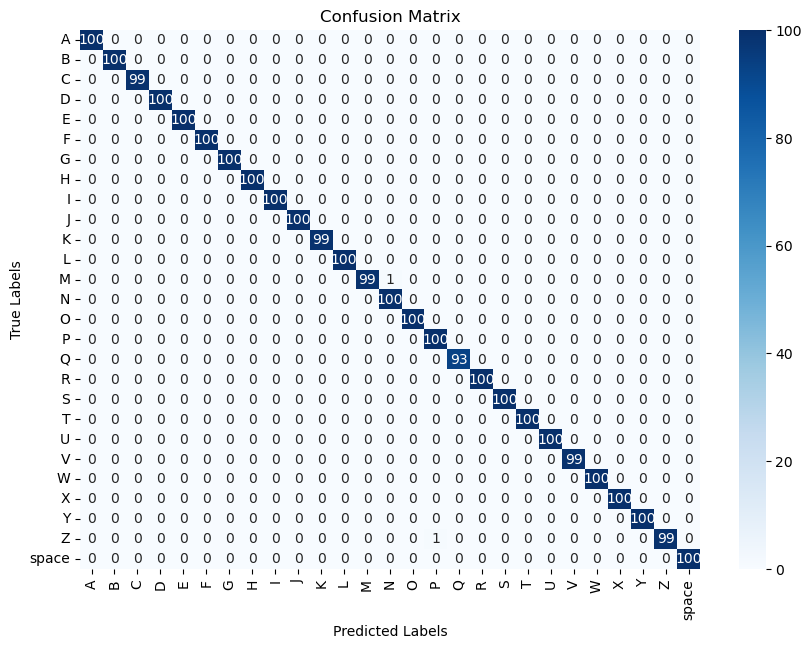

In [4]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# # Standardize the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# for col in X:
#     if col.startswith('x'):
#         df[col] -= df['x0'].values[0]
#     elif col.startswith('y'):
#         df[col] -= df['y0'].values[0]

# Train the Random FNN
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(classification_report(y_test, y_pred))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()






In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# RUN THIS BECAUSE WE NEED THE LABEL ENCODER
from sklearn.preprocessing import LabelEncoder

# Load your data into X and y
# X, y = your_data_loading_function()

# Encode y using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [6]:
# Define the neural network model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(set(y)), activation='softmax'))  # Output layer for classification

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])

# Predict on the test set
y_pred_prob = model.predict(X_test)
y_pred = y_pred_prob.argmax(axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(classification_report(y_test, y_pred))

Epoch 1/20
269/269 [==============================] - 1s 3ms/step - loss: 1.8599 - accuracy: 0.5397 - val_loss: 0.6079 - val_accuracy: 0.8550
Epoch 2/20
269/269 [==============================] - 1s 2ms/step - loss: 0.3285 - accuracy: 0.9229 - val_loss: 0.2407 - val_accuracy: 0.9266
Epoch 3/20
269/269 [==============================] - 0s 2ms/step - loss: 0.1461 - accuracy: 0.9624 - val_loss: 0.1309 - val_accuracy: 0.9624
Epoch 4/20
269/269 [==============================] - 0s 2ms/step - loss: 0.0910 - accuracy: 0.9743 - val_loss: 0.0725 - val_accuracy: 0.9856
Epoch 5/20
269/269 [==============================] - 0s 2ms/step - loss: 0.0629 - accuracy: 0.9825 - val_loss: 0.0575 - val_accuracy: 0.9879
Epoch 6/20
269/269 [==============================] - 0s 2ms/step - loss: 0.0449 - accuracy: 0.9886 - val_loss: 0.0334 - val_accuracy: 0.9935
Epoch 7/20
269/269 [==============================] - 0s 2ms/step - loss: 0.0301 - accuracy: 0.9934 - val_loss: 0.0317 - val_accuracy: 0.9935
Epoch 

In [5]:
# Check for NaN values
nan_values = data.isna().sum()

# Display NaN values
print("NaN values in the dataset:")
print(nan_values)

NaN values in the dataset:
folder      0
filename    0
x0          0
y0          0
x1          0
y1          0
x2          0
y2          0
x3          0
y3          0
x4          0
y4          0
x5          0
y5          0
x6          0
y6          0
x7          0
y7          0
x8          0
y8          0
x9          0
y9          0
x10         0
y10         0
x11         0
y11         0
x12         0
y12         0
x13         0
y13         0
x14         0
y14         0
x15         0
y15         0
x16         0
y16         0
x17         0
y17         0
x18         0
y18         0
x19         0
y19         0
x20         0
y20         0
dtype: int64


In [11]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               5632      
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 27)                891       
                                                                 
Total params: 16,859
Trainable params: 16,859
Non-trainable params: 0
_________________________________________________________________


In [7]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix (y_test , y_pred)  

<Axes: >

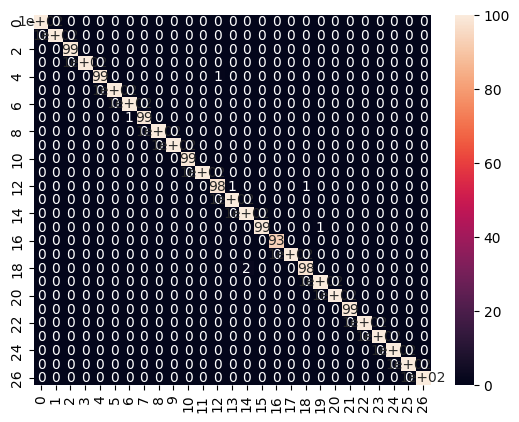

In [9]:
import seaborn as sns

sns.heatmap (cm , annot=True , xticklabels= "auto" , yticklabels= "auto")

In [10]:
model.save ("FNN_ASL_2.h5")

In [5]:
import joblib
import pickle
# Save the model to a file
model_filename = 'random_forest_asl_model_avg_distance.joblib'
joblib.dump(clf, model_filename)
# pickle.dump(clf,open (model_filename , 'wb'))
print(f'Model saved to {model_filename}')

Model saved to random_forest_asl_model_avg_distance.joblib


In [5]:
#RUN THIS FOR INFERENCE
import cv2
import mediapipe as mp
import joblib
import numpy as np
import math

from tensorflow.keras.models import load_model

# Load the model
FNN = load_model("FNN_ASL_2.h5")

# Load the trained model
# model_filename = 'random_forest_asl_model_avg_distance.joblib'
# FNN = joblib.load('FNN_ASL.h5')

# Initialize Mediapipe
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

# def calculate_scale_factor(landmark1, landmark2):
#     # Calculate the Euclidean distance between two landmarks (x, y only)
#     x1, y1 = landmark1
#     x2, y2 = landmark2
#     return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def calculate_avg_distance(landmark1, distance_point_index):
    # Calculate the Euclidean distance between two landmarks (x, y only)
    x1, y1 = landmark1
    total_distance = 0
    for idx in distance_point_index:
        tip_x, tip_y = landmarks[idx]
        distance = math.sqrt((tip_x - x1) ** 2 + (tip_y - y1) ** 2)
        total_distance += distance
    average_distance = total_distance / len(distance_point_index)
    return average_distance







def normalize_landmarks(landmarks, reference_point_index=0, distance_point_index= [4 , 8 , 12 , 20]):
    # Identify the reference point (e.g., wrist)
    ref_x, ref_y = landmarks[reference_point_index]
    
    # Calculate the scale factor using the distance between the reference point and the distance point
    # distance_point = landmarks[distance_point_index]
    avg_distance = calculate_avg_distance(landmarks[reference_point_index], distance_point_index)
    
    # Subtract the reference point coordinates and normalize by the scale factor
    normalized_landmarks = [
        ((x - ref_x) , (y - ref_y))
        for (x, y) in landmarks
    ]
    
    return normalized_landmarks, avg_distance

def prepare_input_for_model(normalized_landmarks , avg_distance):
    # Convert the list of tuples into a numpy array
    normalized_array   = np.array(normalized_landmarks)
    # Flatten the array into a single list
    flattened_array = normalized_array.flatten()
    # Add the scale factor to the flattened array
    final_input = np.append(flattened_array, avg_distance)
    # Reshape the final input into the required format
    return final_input.reshape(1, -1)

# Open webcam
cap = cv2.VideoCapture(0)

while cap.isOpened():
    success, image = cap.read()
    if not success:
        break

    # Convert the BGR image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Process the image and find hands
    results = hands.process(image_rgb)

    # Draw hand landmarks
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
            
            # Extract the x, y coordinates
            landmarks = [(lm.x, lm.y) for lm in hand_landmarks.landmark]
            
            # Normalize the landmarks and get the scale factor
            normalized_landmarks, scale_factor = normalize_landmarks(landmarks)
            
            # Prepare the input for the model
            model_input = prepare_input_for_model(normalized_landmarks, scale_factor)
            
            # Predict the gesture
            gesture_prob = FNN.predict(model_input)
            gesture = gesture_prob.argmax(axis = 1)
            gesture = label_encoder.inverse_transform(gesture)
            
            # Display the predicted gesture on the image
            cv2.putText(image, f'Gesture: {gesture}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

    # Display the image
    cv2.imshow('ASL Detection', image)

    if cv2.waitKey(5) & 0xFF == 27:
        break

cap.release()
cv2.destroyAllWindows()

# Release Mediapipe resources
hands.close()


1/1 [==============================] - 0s 17ms/step
